# Convert ROOT to PANDAS

In [20]:
import os
import root_pandas as rpd
import numpy as np

In [21]:
path = "/pnfs/psi.ch/cms/trivcat/store/user/spigazzi/MTD/TDR/RelValTTbar_Tauola_14TeV/crab_TTbar_mtd5_PMV13_TrackPUID_v1/190222_101038/0000/"
files = [ "root://t3dcachedb03.psi.ch:1094/"+path+ifile for ifile in os.listdir(path) if os.path.isfile(path+ifile) ]

In [22]:
import getpass
password = 'DukeNukem'
cmd = 'voms-proxy-init -voms cms'
os.popen(cmd, 'w').write(password+'\n')

Enter GRID pass phrase for this identity:Contacting voms2.cern.ch:15002 [/DC=ch/DC=cern/OU=computers/CN=voms2.cern.ch] "cms"...
Remote VOMS server contacted succesfully.


Created proxy in /tmp/x509up_u664.

Your proxy is valid until Sat Feb 23 00:57:34 CET 2019


In [23]:
dfs = []
for ifile in files:
    dfs.append([rpd.read_root(ifile, "trks_tree3D", where='pt>0.5'), rpd.read_root(ifile, "trks_tree4D", where='pt>0.5')])

In [24]:
import pandas as pd
df3D = pd.concat([df[0] for df in dfs])
df4D = pd.concat([df[1] for df in dfs])
print(df3D.size/float(df4D.size))

1.00006076742


In [25]:
event_sel3D = (abs(df3D['pv_z']-df3D['genVtx_z'])<0.01) & (df3D['pv_valid']) & (abs(df3D['z']-df3D['pv_z'])<1.)
df3D = df3D[event_sel3D]
pv_pu_ratio_3D = float((df3D['simIsFromPV']==1).sum())/(df3D['simIsFromPV']==0).sum()
df3D['pu_weight'] = 1.
df3D.loc[df3D['simIsFromPV']==0, 'pu_weight'] = pv_pu_ratio_3D

event_sel4D = (abs(df4D['pv_z']-df4D['genVtx_z'])<0.01) & (df4D['pv_valid']) & (abs(df4D['z']-df4D['pv_z'])<1.)
df4D = df4D[event_sel4D]
pv_pu_ratio_4D = float((df4D['simIsFromPV']==1).sum())/(df4D['simIsFromPV']==0).sum()
df4D['pu_weight'] = 1.
df4D.loc[df4D['simIsFromPV']==0, 'pu_weight'] = pv_pu_ratio_4D
print(df3D.size, pv_pu_ratio_3D)
print(df4D.size, pv_pu_ratio_4D)

(272372815, 0.19177879777991105)
(270248990, 0.19251834361517445)


In [26]:
X_rew = df3D[['eta', 'pt']].head(2000000)
y_rew = df3D['simIsFromPV'].head(2000000)
w_rew = df3D['pu_weight'].head(2000000)

In [27]:
from xgboost import XGBClassifier
reweight_clf = XGBClassifier(max_depth=3, n_estimators=200, nthread=8, objective='binary:logistic', subsample=0.75)

In [28]:
reweight_clf.fit(X_rew, y_rew, w_rew)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=8, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [29]:
rew_eta_pt = reweight_clf.predict_proba(df3D[['eta', 'pt']])

In [30]:
s = rew_eta_pt.sum(axis=1)
df3D['eta_pt_weight'] = 1.
df3D.loc[df3D['simIsFromPV']==1, 'eta_pt_weight'] = rew_eta_pt[np.where(df3D['simIsFromPV']==1)][:,0]/rew_eta_pt[np.where(df3D['simIsFromPV']==1)][:,1]
df3D['weight'] = df3D['pu_weight']*df3D['eta_pt_weight']

In [31]:
X_rew = df4D[['eta', 'pt']].head(2000000)
y_rew = df4D['simIsFromPV'].head(2000000)
w_rew = df4D['pu_weight'].head(2000000)

from xgboost import XGBClassifier
reweight_clf = XGBClassifier(max_depth=3, n_estimators=200, nthread=8, objective='binary:logistic', subsample=0.75)

reweight_clf.fit(X_rew, y_rew, w_rew)

rew_eta_pt = reweight_clf.predict_proba(df4D[['eta', 'pt']])

s = rew_eta_pt.sum(axis=1)
df4D['eta_pt_weight'] = 1.
df4D.loc[df4D['simIsFromPV']==1, 'eta_pt_weight'] = rew_eta_pt[np.where(df4D['simIsFromPV']==1)][:,0]/rew_eta_pt[np.where(df4D['simIsFromPV']==1)][:,1]
df4D['weight'] = df4D['pu_weight']*df4D['eta_pt_weight']

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',**{'family':'sans-serif', 'sans-serif':['Helvetica'], 'size':'20'})
plt.rcParams['figure.figsize'] = '10,10'
plt.style.use('seaborn-white')

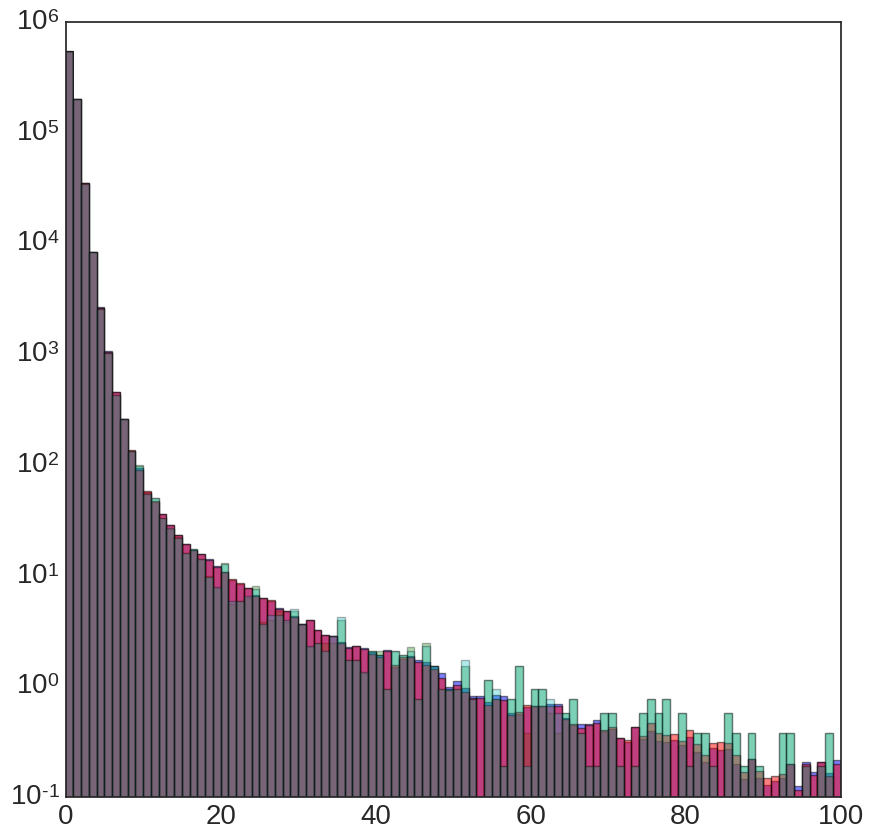

In [33]:
hpv3D = plt.hist(df3D.loc[df3D['simIsFromPV']==1, 'pt'], weights=df3D.loc[df3D['simIsFromPV']==1, 'weight'], range=(0, 100), bins=100, alpha=0.5)
hpu3D = plt.hist(df3D.loc[df3D['simIsFromPV']==0, 'pt'], weights=df3D.loc[df3D['simIsFromPV']==0, 'weight'], range=(0, 100), bins=100, alpha=0.3)
hpv4D = plt.hist(df4D.loc[df4D['simIsFromPV']==1, 'pt'], weights=df4D.loc[df4D['simIsFromPV']==1, 'weight'], range=(0, 100), bins=100, alpha=0.5)
hpu4D = plt.hist(df4D.loc[df4D['simIsFromPV']==0, 'pt'], weights=df4D.loc[df4D['simIsFromPV']==0, 'weight'], range=(0, 100), bins=100, alpha=0.3)

plt.yscale('log')

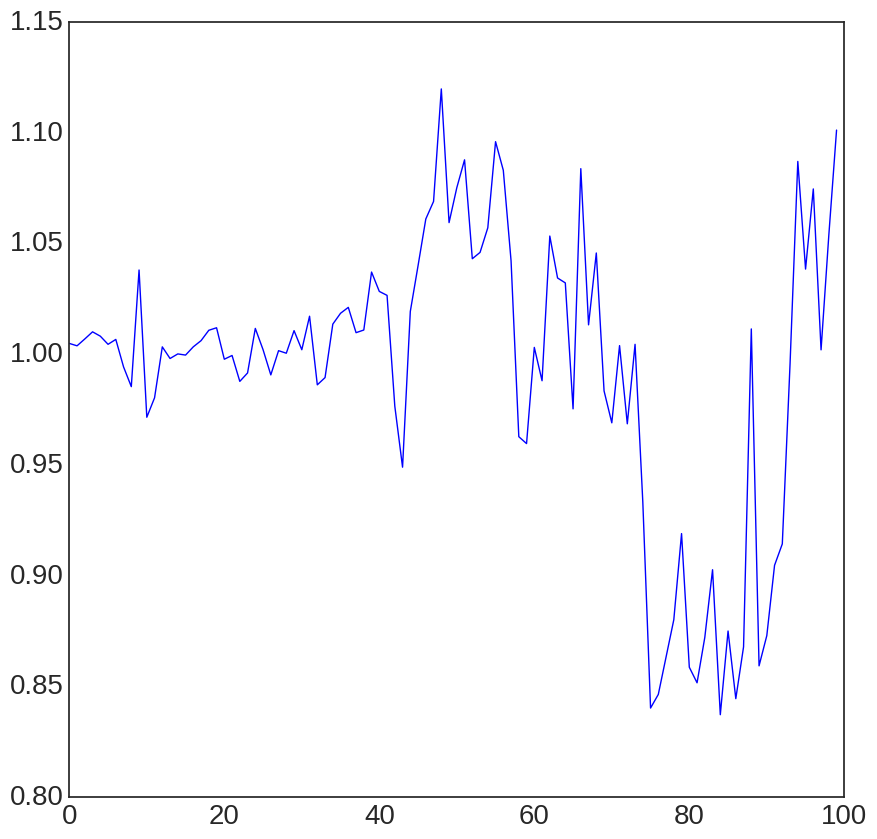

In [34]:
h=plt.plot(hpv3D[1][:-1], np.array(hpv3D[0])/np.array(hpv4D[0]))

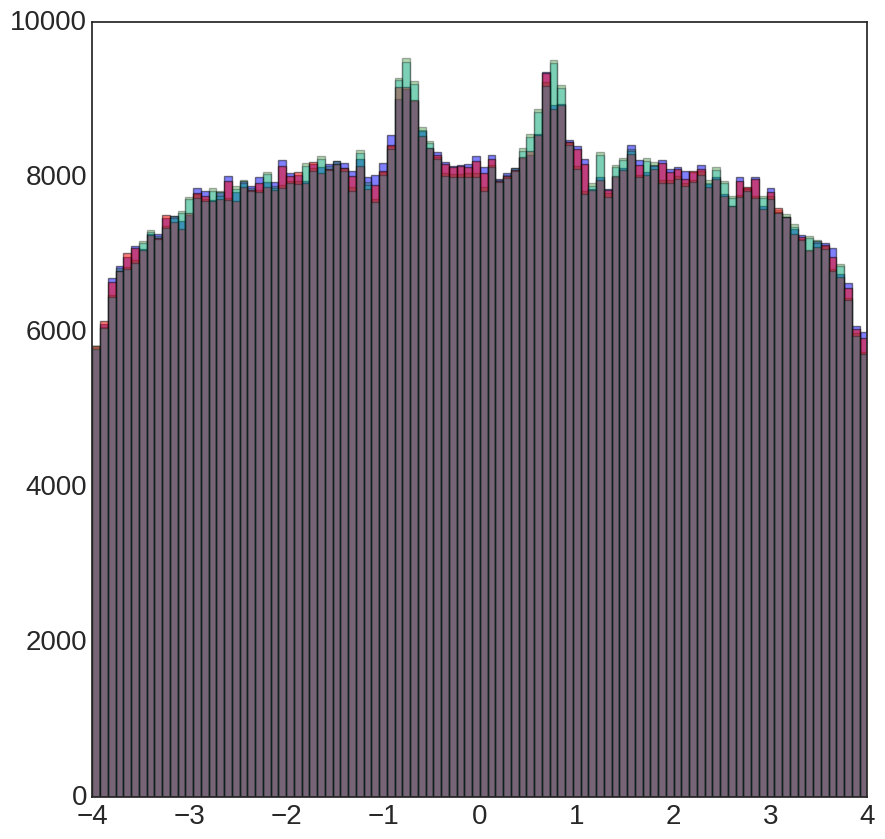

In [35]:
hpv3D = plt.hist(df3D.loc[df3D['simIsFromPV']==1, 'eta'], weights=df3D.loc[df3D['simIsFromPV']==1, 'weight'], range=(-4, 4), bins=100, alpha=0.5)
hpu3D = plt.hist(df3D.loc[df3D['simIsFromPV']==0, 'eta'], weights=df3D.loc[df3D['simIsFromPV']==0, 'weight'], range=(-4, 4), bins=100, alpha=0.3)
hpv4D = plt.hist(df4D.loc[df4D['simIsFromPV']==1, 'eta'], weights=df4D.loc[df4D['simIsFromPV']==1, 'weight'], range=(-4, 4), bins=100, alpha=0.5)
hpu4D = plt.hist(df4D.loc[df4D['simIsFromPV']==0, 'eta'], weights=df4D.loc[df4D['simIsFromPV']==0, 'weight'], range=(-4, 4), bins=100, alpha=0.3)

#plt.yscale('log')

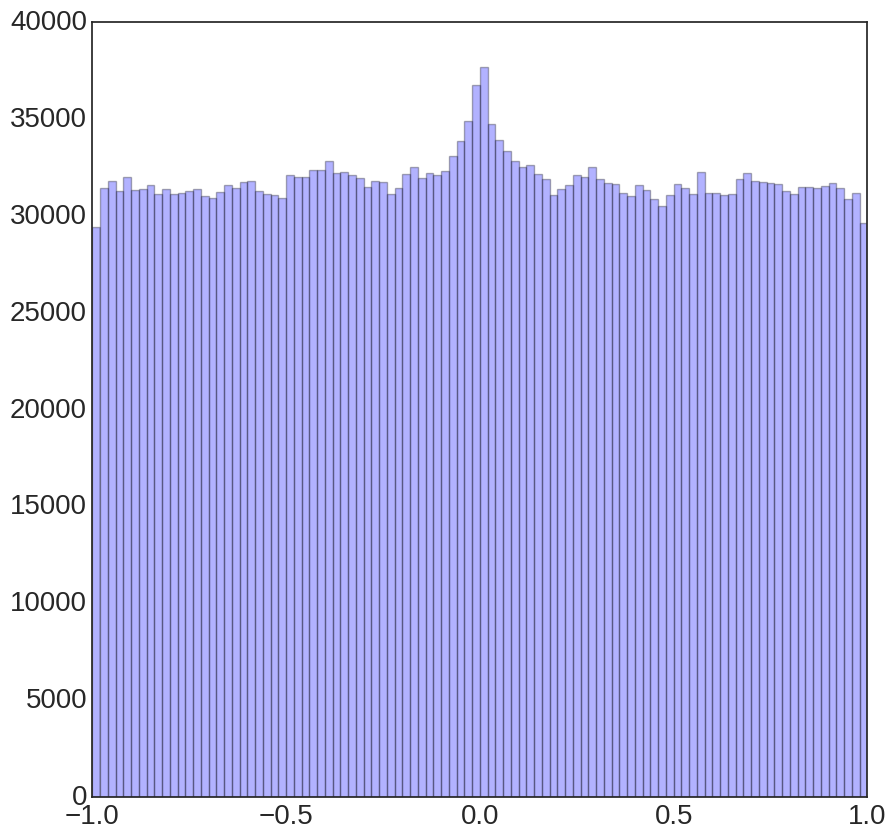

In [36]:
#hpv3D = plt.hist(df3D.loc[df3D['simIsFromPV']==1, 'dz'], range=(-1, 1), bins=100, alpha=0.5)
hpu3D = plt.hist(df3D.loc[(df3D['simIsFromPV']==0) & (abs(df3D['eta'])<3), 'dz'], range=(-1, 1), bins=100, alpha=0.3)
#hpv4D = plt.hist(df4D.loc[df4D['simIsFromPV']==1, 'weight'], range=(0, 2), bins=100, alpha=0.5)
# hpu4D = plt.hist(df4D.loc[df4D['simIsFromPV']==0, 'weight'], range=(0, 2), bins=100, alpha=0.3)

#plt.yscale('log')

In [37]:
from sklearn.model_selection import train_test_split
import pickle

df_train_3D, df_test_3D = train_test_split(df3D, test_size=0.3, random_state=12345)
df_train_4D, df_test_4D = train_test_split(df4D, test_size=0.3, random_state=12345)

df_train_3D.to_hdf('/scratch/spigazzi/MTD/TDR/TrackPUID/samples/ttbar_PMV13_v1/input_tracks_train_3D.hd5','merged',mode='w',format='t')
df_test_3D.to_hdf('/scratch/spigazzi/MTD/TDR/TrackPUID/samples/ttbar_PMV13_v1/input_tracks_test_3D.hd5','merged',mode='w',format='t')
df_train_4D.to_hdf('/scratch/spigazzi/MTD/TDR/TrackPUID/samples/ttbar_PMV13_v1/input_tracks_train_4D.hd5','merged',mode='w',format='t')
df_test_4D.to_hdf('/scratch/spigazzi/MTD/TDR/TrackPUID/samples/ttbar_PMV13_v1/input_tracks_test_4D.hd5','merged',mode='w',format='t')

pickle.dump(reweight_clf, open("/scratch/spigazzi/MTD/TDR/TrackPUID/samples/ttbar_PMV13_v1/eta_pt_reweighter.pkl", "wb"))